# 설명 -SCC안에서 구동할 것

Dense Model를 사용해서 결과를 만듦

- 일단 현재 파일은 아래 경로에 저장된 모델을 대상으로 만들어짐
restricted/projectnb/movelab/bcha/IMUforKnee/trainedModel/Dense_1st_torch/IWALQQ_AE_4th/

In [26]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from torch.utils.tensorboard import SummaryWriter
import os
from os.path import join
from pickle import load
from tqdm import tqdm
import random
import datetime
import pandas as pd
from natsort import natsorted

In [44]:
motherDir = 'DenseModel'
######### 설정 영역 ########
exp_name = 'torch_20220630' # 실험 이름 혹은 오늘 날짜
modelVersion = 'Dense_1st_torch'
nameDataset = 'IWALQQ_AE_4th'
dataType = 'angle' # or moBWHT

# 모델 위치
SaveDir = "/restricted/projectnb/movelab/bcha/IMUforKnee/trainedModel/"
MODEL_DIR = join(SaveDir, modelVersion, nameDataset)
# 데이터 위치
dataDir = "../preperation/SAVE_dataSet"
DATA_DIR = join(dataDir, nameDataset)
# 고정값
SEQ_LEN = 101
NUM_FEATURES = 42
# 인공지능 학습용 세팅
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [28]:
# 데이터셋 불러올때 필요한 것
class MinMaxScalerSensor(MinMaxScaler):
    def fit(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0] * X.shape[1], -1))
        super().fit(x, y=y)

    def transform(self, X):
        x = np.reshape(X, newshape=(X.shape[0] * X.shape[1], -1))
        return np.reshape(super().transform(x), newshape=X.shape)

    def inverse_transform(self, X):
        x = np.reshape(X, newshape=(X.shape[0] * X.shape[1], -1))
        return np.reshape(super().inverse_transform(x), newshape=X.shape)

In [29]:
def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

In [30]:
# 일단 각도 예측 모델
for numFold in range(0, 5):
    # 모델 불러오기
    dir_savedTrainedModel = join(MODEL_DIR, f"{dataType}_{numFold}_fold.pt")
    my_model = torch.jit.load(dir_savedTrainedModel,map_location='cpu')
    my_model.eval()
    # 데이터 불러오기
    load_test = np.load(join(DATA_DIR, f"{numFold}_fold_final_test.npz"))
    load_scaler4Y = load(
        open(join(DATA_DIR, f"{numFold}_fold_scaler4Y_{dataType}.pkl"), "rb")
    )
    # 각 폴드의 개별 데이터 순회
    for dataIndex in range(load_test["final_X_test"].shape[0]):
        # 입력 및 정답 데이터 준비
        X_test = np.squeeze(load_test["final_X_test"][dataIndex])
        X_test = X_test[None, :]  # batch dimension을
        X_dg = np.squeeze(load_test["final_DG_test"][dataIndex])
        Y_true = load_test[f"final_Y_{dataType}_test"][dataIndex]
        # 추론
        Y_pred = my_model(
            torch.from_numpy(X_test).type(torch.FloatTensor))
        Y_pred = Y_pred.cpu().detach().numpy()
        Y_pred = np.reshape(Y_pred, [3, -1])
        Y_pred = np.transpose(Y_pred)
        # 데이터 rescale해서 원래크기로 돌리기
        Y_true_pick_afterscaler = (Y_true - load_scaler4Y.min_) / load_scaler4Y.scale_
        Y_pred_pick_afterscaler = (Y_pred - load_scaler4Y.min_) / load_scaler4Y.scale_
        
        df_true = pd.DataFrame(Y_true_pick_afterscaler, columns=['X_True','Y_True','Z_True'])
        df_pred = pd.DataFrame(Y_pred_pick_afterscaler, columns=['X_Pred','Y_Pred','Z_Pred'])
        df_save =  pd.concat([df_true, df_pred], axis=1)
        dfSaveDir = join(motherDir,modelVersion,nameDataset,dataType,f"{numFold}_fold")
        ensure_dir(dfSaveDir)
        df_save.to_excel(join(dfSaveDir,f"{dataIndex}.xlsx"))
    #     break  # 테스트 데이터 loop break 용도
    # break  # fold loop break 용도

# 총 결과 정리 및 PDF 그리기

In [38]:
# import 필요한 라이브러리
import os
from os.path import join
from natsort import natsorted
from pathlib import Path
import shutil
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [39]:
# 필요한 함수 정의
def meanStdPlot(position,data,name):
    color_X = "#008080"##015734
    color_Y = "#4d019a"#58008f
    linewidth = 2
    
    subAJ_right = 0.5
    subAJ_top = 1.0
    subAJ_wspace = 0.5
    sub_offset= 40

    data = np.array(data).astype(float)
    print('data : ',data.shape)
    
    host = host_subplot(position, axes_class=AA.Axes)
    
    plt.subplots_adjust(right=subAJ_right,top=subAJ_top, wspace=subAJ_wspace)

    par1 = host.twinx()

    par1.axis["right"].toggle(all=True) 


    # host.set_xlim(0, 2)
    # host.set_ylim(0, 2)

    host.set_xlabel(f"Normalized Time")
    host.set_title(
    f"{name}"
    )
    # host.set_ylabel("Angle")
    # par1.set_ylabel("Angle")
    # par2.set_ylabel("Z_axis")

    p1, = host.plot(range(0,len(data[0])), data[0], linewidth=linewidth,label="True",color=color_X)
    host.fill_between(range(0,len(data[0])), data[0]+data[1],data[0]-data[1],alpha=0.2,facecolor=p1.get_color(), edgecolor=(0,0,0,.8))
    p2, = par1.plot(range(0,len(data[0])),  data[2],linewidth=linewidth, label="Pred",color=color_Y)
    par1.fill_between(range(0,len(data[0])), data[2]+data[3],data[2]-data[3],alpha=0.2,facecolor=p2.get_color(),edgecolor=(0,0,0,.8))
    
    if 'angle' in name:
        if 'X' in name:
            host.set_ylim(-55, 0)
            par1.set_ylim(-55, 0)
        elif 'Y' in name:
            host.set_ylim(-10, 10)
            par1.set_ylim(-10, 10)
        elif 'Z' in name:   
            host.set_ylim(-25, 10)
            par1.set_ylim(-25, 10)

    # elif 'moBWHT' in name:
    #     host.set_ylim(0, 4)
    #     par1.set_ylim(0, 4)
     

    host.legend()

    host.axis["left"].label.set_color(color_X)
    par1.axis["right"].label.set_color(color_Y)


    host.axis["left"].major_ticks.set_color(color_X)
    par1.axis["right"].major_ticks.set_color(color_Y)


    host.axis["left"].major_ticklabels.set_color(color_X)
    par1.axis["right"].major_ticklabels.set_color(color_Y)

def diffPlot(position,data,name):
    if "X" in name:
        color_X = "#e05858"
    elif "Y" in name:
        color_X = "#32a852"
    elif "Z" in name:
        color_X = "#4159cc"
    linewidth = 2
    
    subAJ_right = 0.5
    subAJ_top = 1.0
    subAJ_wspace = 0.5
    sub_offset= 40

    data = np.array(data).astype(float)
    print('data : ',data.shape)
    
    host = host_subplot(position, axes_class=AA.Axes)
    
    plt.subplots_adjust(right=subAJ_right,top=subAJ_top, wspace=subAJ_wspace)

    # host.set_xlim(0, 2)
    # host.set_ylim(0, 2)

    host.set_xlabel(f"Normalized Time")
    host.set_title(
    f"{name}"
    )
    # host.set_ylabel("Angle")
    # par1.set_ylabel("Angle")
    # par2.set_ylabel("Z_axis")

    p1, = host.plot(range(0,len(data[0])), data[0], linewidth=linewidth,label="Diff",color=color_X)
    host.fill_between(range(0,len(data[0])), data[0]+data[1],data[0]-data[1],alpha=0.2,facecolor=p1.get_color(), edgecolor=(0,0,0,.8))

    if 'angle' in name:
        host.set_ylim(0, 15)
    elif 'moBWHT' in name:
        host.set_ylim(0, 5)

     

    host.legend()

    host.axis["left"].label.set_color(color_X)

    host.axis["left"].major_ticks.set_color(color_X)

    host.axis["left"].major_ticklabels.set_color(color_X)

In [45]:
# 본 결과를 담을 총 폴더 이름
targetDir = join(motherDir,modelVersion,nameDataset,dataType)

for axe in ["X","Y","Z"]:
    print("Axe : ", axe)
    globals()[f"true_{axe}"] = np.array([])
    globals()[f"pred_{axe}"] = np.array([])
    for fold in ["0_fold","1_fold","2_fold","3_fold","4_fold",]:
        print(f"now fold : ", fold)
        list_results = natsorted([_ for _ in os.listdir(join(targetDir,fold)) if _.endswith(".xlsx")])
        for result in list_results:
            singleResult = pd.read_excel(join(targetDir,fold,result))
            true = np.expand_dims(singleResult[f"{axe}_True"].to_numpy(), axis=0)
            pred = np.expand_dims(singleResult[f"{axe}_Pred"].to_numpy(), axis=0)
            if len(globals()[f"true_{axe}"]) ==0:
                globals()[f"true_{axe}"] = true
                globals()[f"pred_{axe}"] = pred
            else:
                globals()[f"true_{axe}"] = np.concatenate((globals()[f"true_{axe}"], true),0)
                globals()[f"pred_{axe}"] = np.concatenate((globals()[f"pred_{axe}"], pred),0)


Axe :  X
now fold :  0_fold
now fold :  1_fold
now fold :  2_fold
now fold :  3_fold
now fold :  4_fold
Axe :  Y
now fold :  0_fold
now fold :  1_fold
now fold :  2_fold
now fold :  3_fold
now fold :  4_fold
Axe :  Z
now fold :  0_fold
now fold :  1_fold
now fold :  2_fold
now fold :  3_fold
now fold :  4_fold


In [46]:
def makeDataframe(file_Num):
    return pd.DataFrame(data=file_Num.transpose(),index = [idx for idx in range(len(file_Num[0]))],columns=[idx for idx in range(len(file_Num))])

In [47]:
totalDir = join(motherDir,modelVersion,nameDataset,dataType)
writer = pd.ExcelWriter(join(totalDir,'TruePredDiff.xlsx'), engine='xlsxwriter')
for axe in ["X","Y","Z"]:
    for sess in ["true","pred"]:
        dataName = f"{sess}_{axe}"
        df = makeDataframe(globals()[dataName])
        df.to_excel(writer,sheet_name=str(dataName),index=False)
    df_diff = makeDataframe(abs(globals()[f"true_{axe}"]-globals()[f"pred_{axe}"]))
    df_diff.to_excel(writer,sheet_name=str(f"diff_{axe}"),index=False)
writer.save()

data :  (4, 101)
data :  (2, 101)
data :  (4, 101)
data :  (2, 101)
data :  (4, 101)
data :  (2, 101)


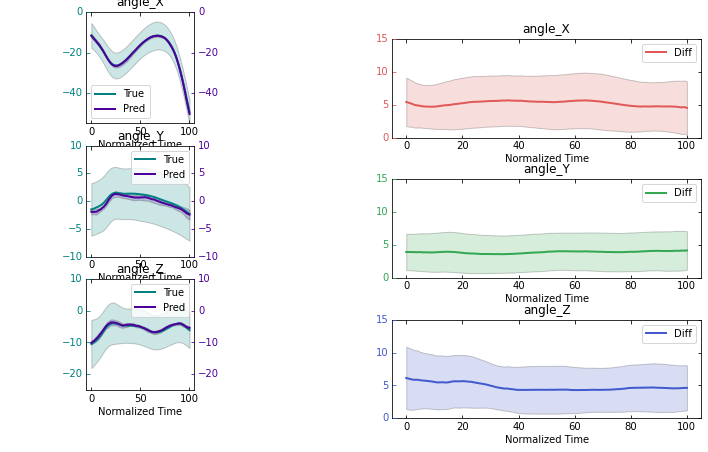

In [48]:
pp = PdfPages(join(targetDir,f"WHOLE_Total_result_{dataType}.pdf"))
# # 축별 살제 예측은 한번에 그리고 에러는 밑에다 그리기
plt.figure(figsize=(10, 6))
meanStdPlot(321,[true_X.mean(axis=0),true_X.std(axis=0),pred_X.mean(axis=0),pred_X.std(axis=0)],f"{dataType}_X")
diffPlot(322,[abs(true_X-pred_X).mean(axis=0),abs(true_X-pred_X).std(axis=0)],f"{dataType}_X")
meanStdPlot(323,[true_Y.mean(axis=0),true_Y.std(axis=0),pred_Y.mean(axis=0),pred_Y.std(axis=0)],f"{dataType}_Y")
diffPlot(324,[abs(true_Y-pred_Y).mean(axis=0),abs(true_Y-pred_Y).std(axis=0)],f"{dataType}_Y")
meanStdPlot(325,[true_Z.mean(axis=0),true_Z.std(axis=0),pred_Z.mean(axis=0),pred_Z.std(axis=0)],f"{dataType}_Z")
diffPlot(326,[abs(true_Z-pred_Z).mean(axis=0),abs(true_Z-pred_Z).std(axis=0)],f"{dataType}_Z")
plt.tight_layout()
pp.savefig()
pp.close()